<a href="https://colab.research.google.com/github/markcam1/machine-learning-00/blob/main/Final_Project_Tech27_Part-03_Cluster-02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering and Predictive Modeling of S&P 500 Stock Price Behaviors

**Part 02 - HDBSCAN retry**

The full dataset’s 1,660,958 rows include noise from daily market fluctuations, which can obscure long-term stock behavior. Aggregating features (e.g., mean, variance, or summary statistics like Sharpe_252d) into a 426-row dataset reduces this noise, providing a cleaner representation of each stock’s profile.
With 32 numerical features per stock, the aggregated dataset (426 rows × 32 features) is computationally manageable for clustering, avoiding memory issues encountered with Agglomerative Clustering on larger datasets.

# Imports

In [ ]:
##########################################
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import hdbscan
import umap.umap_ as umap
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Unsupervised Learning")
print("=" * 60)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


Unsupervised Learning
Analysis Date: 2025-08-28 17:40:46


# Data Load




## File Upload

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/sp500_stocks_feature-eng.csv')

print("File loaded successfully!")
print(df.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File loaded successfully!
         Date Symbol       Open       High        Low      Close     Volume  \
0  2010-02-17      A  19.333031  19.575014  19.186569  19.504965  4891183.0   
1  2010-02-18      A  19.466763  19.740585  19.383981  19.727848  3313959.0   
2  2010-02-19      A  19.638699  19.912520  19.498604  19.867945  4186171.0   
3  2010-02-22      A  19.925251  19.925251  19.645064  19.836102  4038123.0   
4  2010-02-23      A  19.797895  19.842470  19.441291  19.645065  4366373.0   

   Year    Return  Annual_Vol  ...  Volume_MA_30  Volume_Ratio_10d  PV_Trend  \
0  2010  0.008893     0.23301  ...  5.170074e+06          0.724769  0.136982   
1  2010  0.013412     0.23301  ...  5.141005e+06          0.512090  0.201361   
2  2010  0.011673     0.23301  ...  5.172418e+06          0.672281  0.177984   
3  2010 -0.004474     0.23301  ...  5.203850e+06  

# Clustering

HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise)

HDBSCAN is a powerful clustering algorithm based on DBSCAN. Unlike K-Means, it does not require you to specify the number of clusters beforehand. It can find clusters of varying densities and is excellent at identifying and ignoring noise (outliers).

## HDBSCAN


In [ ]:
####################
# Import libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import hdbscan
import umap.umap_ as umap
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

In [ ]:
# Aggregate features per stock
features = [
    'Return_Daily', 'Roll_Vol_30d', 'Annual_Vol', 'MA_5', 'MA_10', 'MA_20', 'MA_50', 'MA_200',
    'Price_to_MA20', 'Price_to_MA50', 'EMA_5', 'EMA_10', 'EMA_12', 'EMA_20', 'EMA_26', 'EMA_50',
    'Price_to_EMA10', 'Price_to_EMA20', 'Price_to_EMA50', 'EMA_Cross_5_10', 'EMA_Cross_10_20',
    'MACD', 'MACD_Signal', 'MACD_Histogram', 'RSI', 'Return_t-1', 'Return_t-2',
    'Volume_MA_10', 'Volume_MA_30', 'Volume_Ratio_10d', 'PV_Trend', 'Sharpe_252d'
]
df_clustering = df.groupby('Symbol').agg({
    **{f: 'mean' for f in features},
    'Sector': 'first',
    'Industry': 'first',
    'Longname': 'first'
}).reset_index()

# Standardize numerical features
scaler = StandardScaler()
df_clustering[features] = scaler.fit_transform(df_clustering[features])

# PCA (retain ~90% variance)
pca = PCA(n_components=0.9)
pca_features = pca.fit_transform(df_clustering[features])
print(f"PCA components: {pca.n_components_}, Variance explained: {sum(pca.explained_variance_ratio_):.2f}")

# UMAP (2D for visualization)
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_features = umap_model.fit_transform(df_clustering[features])

# Add PCA/UMAP to dataset
df_clustering[[f'PCA_{i+1}' for i in range(pca.n_components_)]] = pca_features
df_clustering[['UMAP_1', 'UMAP_2']] = umap_features

# Save clustering dataset
df_clustering.to_csv('/content/drive/MyDrive/clustering_features.csv', index=False)
print("Clustering dataset saved.")

PCA components: 4, Variance explained: 0.91
Clustering dataset saved.



Testing HDBSCAN with PCA input:
min_cluster_size=5, min_samples=1, epsilon=None
  Result: 22 clusters, 243 noise points (57.0%)
  Silhouette: 0.292, Davies-Bouldin: 1.039

min_cluster_size=5, min_samples=1, epsilon=0.5
  Result: 22 clusters, 243 noise points (57.0%)
  Silhouette: 0.292, Davies-Bouldin: 1.039

min_cluster_size=5, min_samples=3, epsilon=None
  Result: 14 clusters, 324 noise points (76.1%)
  Silhouette: 0.417, Davies-Bouldin: 0.739

min_cluster_size=5, min_samples=3, epsilon=0.5
  Result: 14 clusters, 324 noise points (76.1%)
  Silhouette: 0.417, Davies-Bouldin: 0.739

min_cluster_size=10, min_samples=1, epsilon=None
  Result: 9 clusters, 295 noise points (69.2%)
  Silhouette: 0.327, Davies-Bouldin: 0.933

min_cluster_size=10, min_samples=1, epsilon=0.5
  Result: 9 clusters, 295 noise points (69.2%)
  Silhouette: 0.327, Davies-Bouldin: 0.933

min_cluster_size=10, min_samples=3, epsilon=None
  Result: 3 clusters, 337 noise points (79.1%)
  Silhouette: 0.298, Davies-Bouldi

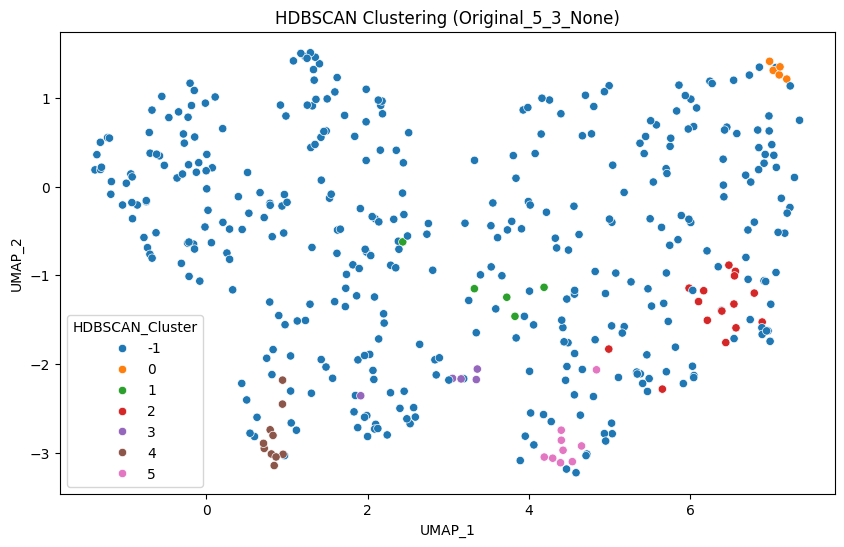

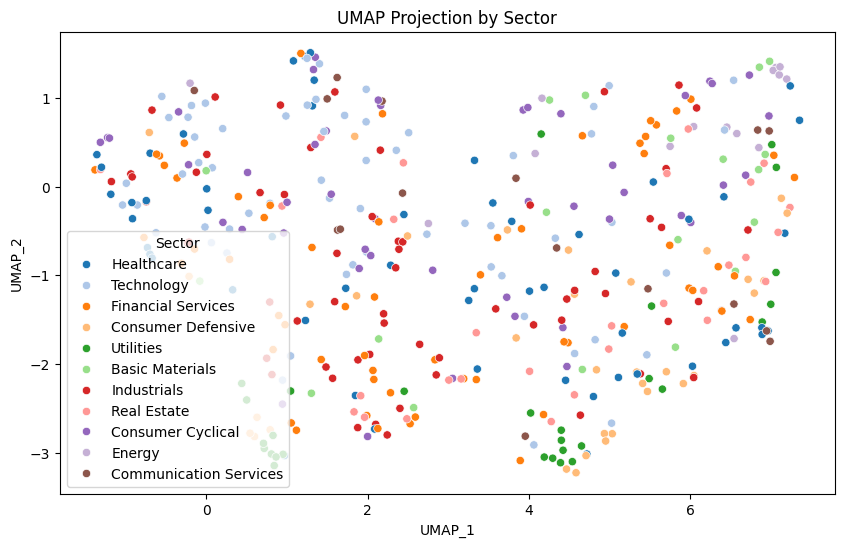

Sector alignment per cluster:
HDBSCAN_Cluster  Sector                
-1               Technology                60
                 Industrials               58
                 Financial Services        57
                 Healthcare                50
                 Consumer Cyclical         42
                 Consumer Defensive        31
                 Real Estate               23
                 Basic Materials           17
                 Communication Services    15
                 Energy                    12
                 Utilities                 12
 0               Energy                     4
                 Basic Materials            1
 1               Consumer Cyclical          2
                 Healthcare                 2
                 Industrials                1
 2               Real Estate                4
                 Financial Services         3
                 Healthcare                 2
                 Utilities                  2
          

In [ ]:
# Load clustering dataset (426 rows, aggregated per stock)
df_clustering = pd.read_csv('/content/drive/MyDrive/clustering_features.csv')

# Define input options
# Correcting pca_columns based on the actual number of components (4)
pca_columns = [f'PCA_{i+1}' for i in range(4)]
features = ['Return_Daily', 'Roll_Vol_30d', 'Annual_Vol', 'MA_5', 'MA_10', 'MA_20', 'MA_50', 'MA_200',
            'Price_to_MA20', 'Price_to_MA50', 'EMA_5', 'EMA_10', 'EMA_12', 'EMA_20', 'EMA_26', 'EMA_50',
            'Price_to_EMA10', 'Price_to_EMA20', 'Price_to_EMA50', 'EMA_Cross_5_10', 'EMA_Cross_10_20',
            'MACD', 'MACD_Signal', 'MACD_Histogram', 'RSI', 'Return_t-1', 'Return_t-2',
            'Volume_MA_10', 'Volume_MA_30', 'Volume_Ratio_10d', 'PV_Trend', 'Sharpe_252d']
X_inputs = {
    'PCA': df_clustering[pca_columns],
    'Original': df_clustering[features],
    'UMAP': df_clustering[['UMAP_1', 'UMAP_2']]
}

# Test HDBSCAN for each input
hdbscan_results = {}
min_cluster_sizes = [5, 10, 15]
min_samples_list = [1, 3]
epsilons = [None, 0.5]

for input_name, X in X_inputs.items():
    print(f"\nTesting HDBSCAN with {input_name} input:")
    for min_size in min_cluster_sizes:
        for min_samp in min_samples_list:
            for eps in epsilons:
                print(f"min_cluster_size={min_size}, min_samples={min_samp}, epsilon={eps}")
                clusterer = hdbscan.HDBSCAN(
                    min_cluster_size=min_size,
                    min_samples=min_samp,
                    cluster_selection_epsilon=eps if eps is not None else 0.0,
                    cluster_selection_method='leaf'
                )
                labels = clusterer.fit_predict(X)

                # Count clusters and noise
                unique_labels = np.unique(labels)
                n_clusters = len(unique_labels[unique_labels >= 0])
                n_noise = np.sum(labels == -1)

                # Compute metrics for valid clusters
                sil_score = np.nan
                db_score = np.nan
                if n_clusters > 1:
                    valid_indices = labels != -1
                    if valid_indices.sum() > 1:
                        sil_score = silhouette_score(X[valid_indices], labels[valid_indices])
                        db_score = davies_bouldin_score(X[valid_indices], labels[valid_indices])

                print(f"  Result: {n_clusters} clusters, {n_noise} noise points ({n_noise/len(labels)*100:.1f}%)")
                if not np.isnan(sil_score):
                    print(f"  Silhouette: {sil_score:.3f}, Davies-Bouldin: {db_score:.3f}")

                # Store results if clusters found
                if n_clusters > 0:
                    key = f"{input_name}_{min_size}_{min_samp}_{eps or 'None'}"
                    hdbscan_results[key] = {
                        'labels': labels,
                        'silhouette': sil_score,
                        'davies_bouldin': db_score,
                        'n_clusters': n_clusters,
                        'n_noise': n_noise,
                        'cluster_sizes': np.bincount(labels[labels >= 0]),
                        'min_cluster_size': min_size,
                        'min_samples': min_samp,
                        'epsilon': eps
                    }

                print()

# Select best configuration (highest silhouette score, 5-10 clusters)
best_key = None
best_silhouette = -1
for key, result in hdbscan_results.items():
    if result['n_clusters'] >= 5 and result['n_clusters'] <= 10 and result['silhouette'] > best_silhouette:
        best_silhouette = result['silhouette']
        best_key = key

if best_key:
    print(f"Best configuration: {best_key}")
    best_result = hdbscan_results[best_key]
    df_clustering['HDBSCAN_Cluster'] = best_result['labels']
else:
    print("No configuration yielded 5-10 clusters. Using best silhouette score or falling back to K-Means.")
    best_key = max(hdbscan_results, key=lambda k: hdbscan_results[k]['silhouette'] if not np.isnan(hdbscan_results[k]['silhouette']) else -1, default=None)
    if best_key:
        best_result = hdbscan_results[best_key]
        df_clustering['HDBSCAN_Cluster'] = best_result['labels']
    else:
        df_clustering['HDBSCAN_Cluster'] = -1  # All noise
        print("HDBSCAN failed to find clusters. Consider K-Means results.")


# Save results
df_clustering[['Symbol', 'HDBSCAN_Cluster', 'Sector', 'Industry', 'Longname', 'UMAP_1', 'UMAP_2']].to_csv(
    '/content/drive/MyDrive/hdbscan_results.csv', index=False
)
print("HDBSCAN clustering results saved.")

# Visualize UMAP with cluster labels
plt.figure(figsize=(10, 6))
sns.scatterplot(x='UMAP_1', y='UMAP_2', hue='HDBSCAN_Cluster', palette='tab10', data=df_clustering)
plt.title(f'HDBSCAN Clustering ({best_key or "No Clusters"})')
plt.savefig(f'/content/drive/MyDrive/hdbscan_umap_plot.png')
plt.show()

# Visualize UMAP with Sector
plt.figure(figsize=(10, 6))
sns.scatterplot(x='UMAP_1', y='UMAP_2', hue='Sector', palette='tab20', data=df_clustering)
plt.title('UMAP Projection by Sector')
plt.savefig(f'/content/drive/MyDrive/hdbscan_sector_umap_plot.png')
plt.show()

# Sector alignment
if best_key:
    print("Sector alignment per cluster:")
    print(df_clustering.groupby('HDBSCAN_Cluster')['Sector'].value_counts())

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/hdbscan_results.csv')
print(df['HDBSCAN_Cluster'].value_counts())
print(df.info())

HDBSCAN_Cluster
-1    377
 2     15
 4     10
 5      9
 3      5
 1      5
 0      5
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426 entries, 0 to 425
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Symbol           426 non-null    object 
 1   HDBSCAN_Cluster  426 non-null    int64  
 2   Sector           426 non-null    object 
 3   Industry         426 non-null    object 
 4   Longname         426 non-null    object 
 5   UMAP_1           426 non-null    float64
 6   UMAP_2           426 non-null    float64
dtypes: float64(2), int64(1), object(4)
memory usage: 23.4+ KB
None
